Link trang web: https://share.streamlit.io/lekiet258/project03_ds/app.py

## BẢNG PHÂN CÔNG

| MSSV     | Họ và tên        | % đóng góp (tối đa 100%) | Chi   tiết công việc         |
|----------|------------------|--------------------------|------------------------------|
| 19120511 | Võ Văn Hiếu      | 100                      | Tiền xử lý tiếng Việt + mô hình Rain Forest                         |
| 19120526 | Huỳnh Đức Huy    | 100                      | Mô hình Decision Tree + code/deploy trang Web                        |
| 19120539 | Vương Thế Khang  | 100                      | EDA (Khám phá dữ liệu) + code Streamlit                         |
| 19120554 | Lê Kiệt          | 100                      | Mô hình Linear Regression Web + Soạn báo cáo                       |
| 19120586 | Nguyễn Phát Minh | 100                      | Mô hình Logistic Regression + xây dựng Pipeline quá trình huấn luyện                           |

# THƯ VIỆN

* Note: trong Project nhóm có sử dụng thư viện `underthesea`. Nếu thầy cô chưa có thư viện này có thể tháo comment cell phía dưới để cài đặt thư viện
* Link tham khảo: https://underthesea.readthedocs.io/en/latest/readme.html

In [1]:
# !pip install underthesea

In [2]:
import pandas as pd
import re
import joblib
import requests

from underthesea import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score

# I. KHÁM PHÁ DỮ LIỆU

Đọc dữ liệu từ file "vn_news_223_tdlft.csv" và lưu vào dataframe `news_df`.

In [3]:
news_df = pd.read_csv('vn_news_223_tdlfr.csv')
news_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\r...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
news_df.shape

(223, 3)

Vậy dữ liệu có kích thước **223 dòng x 3 cột**

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin về một bài báo, có vẻ như không có vấn đề các dòng có ý nghĩa khác nhau.

### Dữ liệu có các dòng bị lặp không?

Kiểm tra xem dữ liệu có các dòng bị lặp không và lưu kết quả vào biến `have_duplicated_row`. Biến này sẽ có giá trị True nếu dữ liệu có các dòng bị lặp và có giá trị False nếu ngược lại.

In [5]:
have_duplicated_row = all(news_df.duplicated())
have_duplicated_row

False

Như vậy, không có dòng nào bị lặp lại.

### Mỗi cột có ý nghĩa gì?

Thông tin về các cột như sau:
- **text:** nội dung của bài báo
- **domain:** tên miền (website)
- **label:** nhãn (1: tin giả, 0: tin thật)

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Xem thử kiểu dữ liệu của các cột dữ liệu

In [6]:
news_df.dtypes

text      object
domain    object
label      int64
dtype: object

$\to$ Có vẻ các cột đều có kiểu dữ liệu phù hợp. Nếu trong quá trình phân tích dữ liệu cần phải thay đổi kiểu dữ liệu của các cột thì ta sẽ quay lại tiền xử lý ở đây, tạm thời ta chấp nhận kiểu dữ liệu hiện tại của các cột.

### Kiểm tra phân bố các lớp/nhãn

Cột `label` có 2 giá trị 1 hoặc 0. Ta sẽ xem phân bố của 2 nhãn này

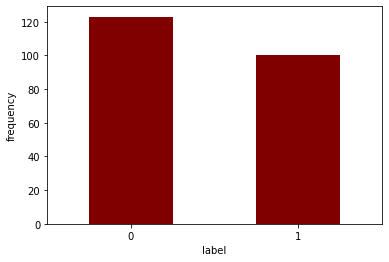

In [7]:
news_df['label'].value_counts().plot.bar(xlabel = 'label', ylabel = 'frequency', rot = 0, color = 'maroon');

$\to$ Phân bố 2 nhãn không quá chênh lệch

### Các thông tin thống kê của văn bản

Các thông tin thống kê bao gồm:
- Chiều dài trung bình của mỗi record.
- ...

In [8]:
print('Chiều dài trung bình của các text:', news_df['text'].apply(len).mean().round())

Chiều dài trung bình của các text: 2555.0


# II. TIỀN XỬ LÝ VĂN BẢN TIẾNG VIỆT

Ở phần này, ta tiền xử lý văn bản cho cột `text` để chuẩn bị cho pipeline xử lý lúc sau. Mỗi phần tử trong pipeline là 1 class "transformer" nên để làm việc với pipeline lúc sau, định nghĩa 1 class "transformer" `TextReducer` thừa kế 2 class `BaseEstimator`, `TransformerMixin` dùng để tiền xử lý văn bản tiếng Việt với 3 phương thức
- **init()**: trong đây lưu trữ danh sách các stopwords được lấy từ [link stopwords](https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt). Danh sách được lưu vào `self.stopwords`
- **fit()**: nhận 2 tham số X là 1 danh sách các đoạn text, y là danh sách label. Tuy nhiên trong ngữ cảnh này ta sẽ không tùy chỉnh hàm fit mà trả về chính nó (self) luôn
- **transform()**: nhận 1 tham số X là danh sách các đoạn text cần tiền xử lý, trả về 1 Series các đoạn text đã qua tiền xử lý. Trong hàm này, tiền xử lý văn bản tiếng Việt theo các bước sau: 
    - Bước 1: loại bỏ các đường dẫn URL (Ví dụ: http, https)
    - Bước 2: loại bỏ ký tự đặc biệt ([@#/!.\'‘’\"“”–+-=()%) và thay dấu dấu xuống hàng (\r\n) thành dấu cách
    - Bước 3: đổi các đoạn text đang có cả chữ hoa và chữ thường thành toàn bộ chữ thường
    - Bước 4: tokenize các đoạn văn bản để với mỗi văn bản chỉ còn là danh sách các từ khóa nội dung của từng văn bản đó. Nhóm quyết định sử dụng hàm `word_tokenize` của thư viện `underthesea` để tokenize các từ tiếng Việt
    - Bước 5: loại bỏ stopwords dựa vào danh sách stopwords đã lưu vào `self.stopwords`.

In [9]:
class TextReducer(BaseEstimator, TransformerMixin):
    stopwords_raw_url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"

    def __init__(self):
        self.stopwords = requests.get(self.stopwords_raw_url).text.split('\n')

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        _X = pd.Series(X)

        # Bước 1
        _X = _X.apply(lambda text: re.sub(r'http(s?)\S+.', '', text))
        # Bước 2
        _X = _X.apply(lambda text: re.sub(r'[@#/!.\'‘’\"“”–+-=()%]', '', text))
        _X = _X.apply(lambda text: re.sub(r'\r\n', ' ', text))
        # Bước 3
        _X = _X.apply(lambda text: text.lower())
        # Bước 4
        _X = _X.apply(word_tokenize)
        # Bước 5
        _X = _X.apply(lambda words: ' '.join([word for word in words if word not in self.stopwords]))

        return _X

# III. MÔ HÌNH HÓA

Ở phần này, nhóm sử dụng 2 mô hình tuyến tính (Linear Regression và Logistic Regression) + 2 mô hình phi tuyến (Random Forest và Decision Tree). Để sử dụng dữ liệu văn bản cho mô hình dự đoán, văn bản phải được phân tích cú pháp để loại bỏ một số từ nhất định(chính là bước tiền xử lý tiếng Việt ở trên). Sau đó, những từ này cần được mã hóa dưới dạng số nguyên hoặc giá trị dấu phẩy động, để sử dụng làm đầu vào trong thuật toán học máy. Quá trình này được gọi là **trích xuất đặc trưng** (hay vectơ hóa/vectorize). Như vậy, với mỗi mô hình, sử dụng 2 vectorizer khác nhau:
- `CountVectorizer()`: dủng để tính tần số xuất hiện của từng token trong văn bản (token có thể là 1 từ hoặc nhiều từ - đã có ở bước tokenize trong tiền xử lý văn bản tiếng Việt) 
- `TfidfVectorizer()`: dùng để tính độ quan trọng (tf-idf) của từng token trong văn bản. Những token có giá trị tf-idf cao là những token xuất hiện nhiều trong văn bản này và xuất hiện ít trong các văn bản khác. Việc này giúp lọc ra những từ phổ biến và giữ lại những từ có giá trị cao (từ khoá của văn bản đó)
---

Để thuận tiện cho việc gọi hàm ở cell sau đó (vì 4 mô hình x 2 vectorizer = 8 mô hình nên nếu không dùng hàm sẽ rất bất tiện và dài dòng), tại cell này làm những công việc sau:
- Lưu 4 mô hình vào dictionary `classifiers` với 4 key là tên viết tắt của tên mô hình như code
- Lưu 2 vectorizer vào dictionary `vectorizers`, cách viết key tương tự như của biến `classifiers`
- Lưu class TextReducer dùng để tiền xử lý văn bản tiếng Việt vào dictionary 1 phần tử `preprocessors`

In [10]:
preprocessors = {'tr':TextReducer()}

vectorizers = {'cv':CountVectorizer(), 
               'tv':TfidfVectorizer()}

classifiers = {'li':LinearRegression(), 
               'lo':LogisticRegression(random_state=42), 
               'dt':DecisionTreeClassifier(random_state=42), 
               'rf':RandomForestClassifier(random_state=42)}

Định nghĩa hàm `generate_models` nhận các tham số 
- `preprocessors`, `vectorizers`, `classifiers`: chính là 3 dictionary ở cell phía trên
- `X_train`, `y_train`: bộ dữ liệu huấn luyện. Trong đó y_train là Series 1 cột thể hiện nhãn 1 hoặc 0 và X_train là 1 dataframe có
2 cột text, domain
- `out`: tên **folder** dùng để lưu các file mô hình (file nhị phân có đuôi .pkl) 

Công việc của hàm `generate_models`: 
- Lần lượt nhóm từng phương thức vector hóa trong `vectorizers` với từng mô hình trong `classifiers` (do hiện tại `preprocessors` chỉ có 1 phần tử nên không quan trọng lắm). Với mỗi lần nhóm:
    - Tạo ra pipeline gồm 3 bước: tiền xử lý + vector hóa + mô hình phân lớp
    - Tiến hành fit tập dữ liệu train vào pipeline vừa tạo
    - Dự đoán nhãn cho tập train và tính độ đo accuracy giữa kết quả dự đoán (y_pred) và kết quả train (y_train). Độ đo này là 1 số thực trong khoảng [0%, 100%] và được lưu kèm với tên mô hình trong biến kết quả trả về tên là `accuracies` (tức `accuracies` là 1 dict có `key` là tên mô hình và `val` là độ chính xác accuracy_score giữa y_pred và y_train). Mục đích là để đánh giá từng mô hình  
    - Lưu mô hình vừa huấn luyện vào file nhị phân .pkl. file này được đặt tên: 
    
      **<preprocessor sử dụng>\_<vectorizer sử dụng>_<classifier sử dụng>**.pkl\. Trong đó:

      |                      | Viết tắt                                                                                       |
      |----------------------|------------------------------------------------------------------------------------------------|
      | preprocessor sử dụng | tr = Text Reducer                                                                              |
      | vectorizer sử dụng   | cv = Count Vectorizer<br>tv = Tfidf Vectorizer                                                 |
      | classifier sử dụng   | li = Linear Regression<br>lo = Logistic Regression<br>dt = Decision Tree<br>rf = Random Forest |

<p>

- **Lưu ý**: khi gọi hàm `accuracy_score` để tính độ chính xác giữa y_train và y_test trên mô hình Linear Regression sẽ bị lỗi "<font color='red'>Classification metrics can't handle a mix of binary and continuous targets</font>". Đó là do kết quả thực tế y_train là **binary outcome** (tức 0 và 1), còn mô hình Linear Regression dự đoán y_pred ra các giá trị số thực và các giá trị này cực kỳ gần 0 (VD: 9.99999e-18 ~ 0) hoặc gần 1 (VD: 1.000000001 ~ 1). Và lỗi này chỉ xảy ra với mô hình Linear Regression nên ta sẽ try..catch để khi có lỗi, chỉ cần làm tròn số về 1 hoặc 0

In [11]:
def generate_models(preprocessors, vectorizers, classifiers, X_train, y_train, out):
    accuracies = dict()
    
    for p in preprocessors:
        for v in vectorizers:
            for c in classifiers:
                pipeline = Pipeline([('text_reducer', preprocessors[p]),
                                     ('vectorizer'  , vectorizers[v]),
                                     ('classifier'  , classifiers[c])])
                # train mô hình
                pipeline.fit(X_train, y_train)
                
                # lưu kết quả dự đoán để đánh giá mô hình
                y_pred = pipeline.predict(X_train)
                try:
                    acc = accuracy_score(y_train, y_pred) * 100
                except:
                    acc = accuracy_score(y_train, y_pred.round()) * 100
                accuracies[p + '_' + v + '_' + c] = acc
                
                # lưu mô hình vào file .pkl
                filepath = out.rstrip('\\').rstrip('/') + '/' + p + '_' + v + '_' + c + '.pkl'
                joblib.dump(pipeline, filepath, compress = 1)
    return accuracies

In [ ]:
X_train = news_df['text']
y_train = news_df['label']

train_accuracies = generate_models(preprocessors, vectorizers, classifiers, X_train, y_train, 'models')
train_accuracies # chạy khoảng 4p

- Đánh giá mô hình: Vì sử dụng toàn bộ tập train làm tập test, thêm nữa tập train có khá ít dữ liệu nên hầu hết các mô hình (kèm với vectorizer tương ứng) đều cho kết quả dự đoán đúng là 100%, ngoại trừ mô hình Logistic Regression với tfidf vectorizer chỉ đoán đúng khoảng 97% 

# IV. Deploy mô hình

- Phần này sử dụng thư viện Streamlit và làm trong file `app.py`